# Simulating DCT Transform with CNN

2020-09-21 Chen-hsiu Huang

This notebook uses a typical [convolutional auto-encoder](https://blog.keras.io/building-autoencoders-in-keras.html) (CAE) to simulate the forward and inverse DCT transform used in JPEG image compression. To completely mimic DCT transform, I use the same 8x8 image block as JPEG's 8x8 DCT transform and design the bottleneck layer as a 64-dimensional vector, which is the same as a typical 8x8 DCT coefficient block. Let's see how good a CNN can approximate the DCT transform.  

First of all, let's import the necessary modules and define some helper functions. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
from PIL import Image
import scipy
import numpy as np
from torch.optim import Adam
from torch.autograd import Variable
import sys
import glob
import random
import datetime
import skimage.metrics
from matplotlib import pyplot as plt 

random.seed(datetime.datetime.now())

def dct2(a):
    return scipy.fft.dct( scipy.fft.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fft.idct( scipy.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def non_overlap_crop(im, patch_size=64, stride=64):
    w, h = im.size
    patches = []
    dcts = []
    rects = []
    for i in range(0, h, stride):
        if i + stride > h:
            continue
        for j in range(0, w, stride):
            if j + stride > w:
                continue
            px = np.array(im.crop((j, i, j + patch_size, i + patch_size)))
            dcts.append(dct2(px))
            patches.append(px)
            rects.append((j, i))
    return patches, dcts, rects

def predict_image(model, patches, batch_size):
    re_px = []
    re_dct = []
    with torch.no_grad():
        for i in range(0, len(patches), batch_size):
            patch = patches[i:i + batch_size]
            patch = torch.stack(patch).to(device)
            r, c = model(patch)
            r = r.squeeze(1).cpu().numpy()
            r = r.clip(0, 255).astype(np.uint8)
            c = c.cpu().numpy()
            
            for j in range(r.shape[0]):
                re_px.append(r[j])
                re_dct.append(c[j])
    return re_px, re_dct

def reconstruct_image(re_px, rects, im_size):
    canvas = Image.new('L', im_size)
    for i in range(len(re_px)):
        pos = rects[i]
        px = Image.fromarray(re_px[i])
        canvas.paste(px, (pos[0], pos[1], pos[0] + BK_SIZE, pos[1] + BK_SIZE))
    return canvas

def estimate_image(re_px, re_dct, patches, dcts, rects, im):
    canvas = Image.new('L', im.size)
    err_px, err_dct = 0, 0
    for i in range(len(re_px)):
        pos = rects[i]
        rpx = Image.fromarray(re_px[i])
        px = patches[i].squeeze(0).cpu().numpy().astype(int)
        dct = dcts[i].numpy()
        rdct = re_dct[i]
        err_px += (np.linalg.norm(px - rpx, ord=1) / (BK_SIZE * BK_SIZE))
        err_dct += (np.linalg.norm(dct - rdct, ord=1) / (BK_SIZE * BK_SIZE))
        canvas.paste(rpx, (pos[0], pos[1], pos[0] + BK_SIZE, pos[1] + BK_SIZE))
    err_px /= len(patches)
    err_dct /= len(patches)
    psnr = skimage.metrics.peak_signal_noise_ratio(np.array(im), np.array(canvas))
    return psnr, err_px, err_dct


## Network Architecture

Here I use two convolution layers of 3x3 kernel size in both encoder and decoder. In the encoder, the input 8x8 image is down-sampled twice with max-pooling to form a 2x2 filter with 16 feature maps, then flattened to a 64-dimensional vector as latent code (bottleneck layer). Please note that I don't use the ```ReLU()``` function after the second convolution layer because we want to preserve the negative values to simulate DCT coefficients. 

Our goal is to approximate the DCT transform so that the reconstructed 8x8 image is similar to the input image, and the latent code is very close to the transformed 8x8 DCT coefficients. 

In [ ]:
EPOCHS = 100
BK_SIZE = 8
BATCH_SIZE = 256
MODEL_FILE = 'pseudo_trans.pth'

class JDCTNet(nn.Module):
    def __init__(self):
        super(JDCTNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 16, 3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.code = nn.Linear(16 * 8 * 8, BK_SIZE * BK_SIZE)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.ReLU(),
        )
    
    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        c = torch.flatten(x, 1)
        r = self.decode(x)
        return r, c


## Dataset

Now we need some images for training and testing. I choose the [UCID dataset](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/5307/0000/UCID-an-uncompressed-color-image-database/10.1117/12.525375.full) to train our CNN<sup>1</sup>, and the [Kodak dataset](http://r0k.us/graphics/kodak/) is for testing. The training set gives us 2.7 million 8x8 patches to train our CNN. Then we verify the approximation result on the 24 images of Kodak. 

<sup>1</sup> The link in the original paper is not working. [This link](http://jasoncantarella.com/downloads/ucid.v2.tar.gz) works, but the file seems broken. I can only extract 886 images from it. 

In [55]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class JDCTDataset(VisionDataset):
    def __init__(self, root, is_train=True, max_items=-1, transform=None, target_transform=None):
        super(JDCTDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.im_names = glob.glob(self.root)
        if max_items != -1:
            random.shuffle(self.im_names)
            self.im_names = self.im_names[:max_items]
        self.patches = [] 
        self.dcts = []
        self.rects = []
        self.images = []
        for i, im_name in enumerate(self.im_names):
            sys.stderr.write(f'load {i+1}/{len(self.im_names)} image\r')
            im = Image.open(im_name).convert('L')
            patches, dcts, rects = non_overlap_crop(im, BK_SIZE, BK_SIZE)
            t_patch = ()
            t_dct = ()
            for i in range(len(patches)):
                t_patch = t_patch + (torch.from_numpy(patches[i]).float().unsqueeze(0), )
                t_dct = t_dct + (torch.from_numpy(dcts[i]).float().view(BK_SIZE * BK_SIZE),)
            if is_train:
                self.patches += t_patch
                self.dcts += t_dct
            else:
                self.patches.append(t_patch)
                self.dcts.append(t_dct)
                self.rects.append(rects)
                self.images.append(im)
        print(f'load from {root}, {len(self.im_names)} images, {len(self.patches)} items')

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.dcts[idx]

test_dataset = JDCTDataset('/home/chenhsiu/dataset/kodak/*.png', is_train=False)

train_dataset = JDCTDataset('/home/chenhsiu/dataset/ucid/*.png', is_train=True, max_items=-1)
loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)


load from /home/chenhsiu/dataset/kodak/*.png, 24 images, 24 items


load from /home/chenhsiu/dataset/ucid/*.png, 886 images, 2721792 items


## Loss Function and Training 

I design the loss function as the sum of reconstruction error plus L1 loss between latent code and DCT coefficients. We train our network for 100 epochs, and the best one gives us an average PSNR 35.3742 on the Kodak dataset. Generally, the PSNR value of 35.37 is not considered as high, but the reconstruction error is only 0.4542 per-pixel, which is quite close to the original image. 

Train Epoch: 1/100 [None] Average loss: 20.7227562        


Test  Epoch: 1/100 [None] PSNR: 32.2211, pixel error: 0.7666 DCT error: 8.7185                   


Train Epoch: 2/100 [1] Average loss: 13.3764963        


Test  Epoch: 2/100 [1] PSNR: 33.5901, pixel error: 0.5967 DCT error: 8.1481                   


Train Epoch: 3/100 [2] Average loss: 12.6641599        


Test  Epoch: 3/100 [2] PSNR: 33.3304, pixel error: 0.6344 DCT error: 7.8748                   


Train Epoch: 4/100 [3] Average loss: 12.3002634        


Test  Epoch: 4/100 [3] PSNR: 33.8480, pixel error: 0.5727 DCT error: 7.7523                   


Train Epoch: 5/100 [4] Average loss: 12.0645766        


Test  Epoch: 5/100 [4] PSNR: 34.0016, pixel error: 0.5481 DCT error: 7.6648                   


Train Epoch: 6/100 [5] Average loss: 11.9200669        


Test  Epoch: 6/100 [5] PSNR: 33.5406, pixel error: 0.5909 DCT error: 7.6199                   


Train Epoch: 7/100 [6] Average loss: 11.8084976        


Test  Epoch: 7/100 [6] PSNR: 33.9903, pixel error: 0.5498 DCT error: 7.5650                   


Train Epoch: 8/100 [7] Average loss: 11.7168513        


Test  Epoch: 8/100 [7] PSNR: 34.3179, pixel error: 0.5119 DCT error: 7.5226                   


Train Epoch: 9/100 [8] Average loss: 11.6490539        


Test  Epoch: 9/100 [8] PSNR: 33.9562, pixel error: 0.5661 DCT error: 7.4952                   


Train Epoch: 10/100 [8] Average loss: 11.5965481        


Test  Epoch: 10/100 [8] PSNR: 34.1657, pixel error: 0.5314 DCT error: 7.4974                   


Train Epoch: 11/100 [10] Average loss: 11.5420565        


Test  Epoch: 11/100 [10] PSNR: 34.1662, pixel error: 0.5428 DCT error: 7.4499                   


Train Epoch: 12/100 [11] Average loss: 11.4993101        


Test  Epoch: 12/100 [11] PSNR: 34.2223, pixel error: 0.5213 DCT error: 7.4537                   


Train Epoch: 13/100 [12] Average loss: 11.4624799        


Test  Epoch: 13/100 [12] PSNR: 34.2189, pixel error: 0.5276 DCT error: 7.4455                   


Train Epoch: 14/100 [13] Average loss: 11.4294923        


Test  Epoch: 14/100 [13] PSNR: 34.1092, pixel error: 0.5424 DCT error: 7.4027                   


Train Epoch: 15/100 [14] Average loss: 11.3992338        


Test  Epoch: 15/100 [14] PSNR: 34.2159, pixel error: 0.5263 DCT error: 7.4406                   


Train Epoch: 16/100 [14] Average loss: 11.3786544        


Test  Epoch: 16/100 [14] PSNR: 34.3443, pixel error: 0.5032 DCT error: 7.3858                   


Train Epoch: 17/100 [16] Average loss: 11.3571567        


Test  Epoch: 17/100 [16] PSNR: 34.0446, pixel error: 0.5291 DCT error: 7.3814                   


Train Epoch: 18/100 [16] Average loss: 11.3354589        


Test  Epoch: 18/100 [16] PSNR: 33.9864, pixel error: 0.5414 DCT error: 7.3772                   


Train Epoch: 19/100 [16] Average loss: 11.3191163        


Test  Epoch: 19/100 [16] PSNR: 34.3726, pixel error: 0.4967 DCT error: 7.3761                   


Train Epoch: 20/100 [19] Average loss: 11.3002845        


Test  Epoch: 20/100 [19] PSNR: 34.3214, pixel error: 0.4909 DCT error: 7.3638                   


Train Epoch: 21/100 [20] Average loss: 11.2848641        


Test  Epoch: 21/100 [20] PSNR: 34.1869, pixel error: 0.5205 DCT error: 7.3557                   


Train Epoch: 22/100 [20] Average loss: 11.2698357        


Test  Epoch: 22/100 [20] PSNR: 33.4583, pixel error: 0.6138 DCT error: 7.4715                   


Train Epoch: 23/100 [20] Average loss: 11.2534461        


Test  Epoch: 23/100 [20] PSNR: 34.3145, pixel error: 0.4981 DCT error: 7.3424                   


Train Epoch: 24/100 [23] Average loss: 11.2481757        


Test  Epoch: 24/100 [23] PSNR: 33.7903, pixel error: 0.6475 DCT error: 7.3446                   


Train Epoch: 25/100 [23] Average loss: 11.2330602        


Test  Epoch: 25/100 [23] PSNR: 34.0513, pixel error: 0.5442 DCT error: 7.3382                   


Train Epoch: 26/100 [23] Average loss: 11.2255899        


Test  Epoch: 26/100 [23] PSNR: 33.4364, pixel error: 0.6302 DCT error: 7.3283                   


Train Epoch: 27/100 [23] Average loss: 11.2045482        


Test  Epoch: 27/100 [23] PSNR: 34.4459, pixel error: 0.4812 DCT error: 7.3408                   


Train Epoch: 28/100 [27] Average loss: 11.1991789        


Test  Epoch: 28/100 [27] PSNR: 34.3587, pixel error: 0.5045 DCT error: 7.3169                   


Train Epoch: 29/100 [28] Average loss: 11.1878528        


Test  Epoch: 29/100 [28] PSNR: 34.0859, pixel error: 0.5374 DCT error: 7.3132                   


Train Epoch: 30/100 [28] Average loss: 11.1741771        


Test  Epoch: 30/100 [28] PSNR: 34.4765, pixel error: 0.4881 DCT error: 7.3050                   


Train Epoch: 31/100 [30] Average loss: 11.1687678        


Test  Epoch: 31/100 [30] PSNR: 34.0667, pixel error: 0.5296 DCT error: 7.3083                   


Train Epoch: 32/100 [30] Average loss: 11.1532770        


Test  Epoch: 32/100 [30] PSNR: 34.3994, pixel error: 0.4941 DCT error: 7.3006                   


Train Epoch: 33/100 [30] Average loss: 11.1452581        


Test  Epoch: 33/100 [30] PSNR: 34.1979, pixel error: 0.5513 DCT error: 7.4030                   


Train Epoch: 34/100 [30] Average loss: 11.1429383        


Test  Epoch: 34/100 [30] PSNR: 34.3821, pixel error: 0.5040 DCT error: 7.3256                   


Train Epoch: 35/100 [30] Average loss: 11.1251734        


Test  Epoch: 35/100 [30] PSNR: 34.2839, pixel error: 0.5247 DCT error: 7.2908                   


Train Epoch: 36/100 [30] Average loss: 11.1196787        


Test  Epoch: 36/100 [30] PSNR: 34.5029, pixel error: 0.4892 DCT error: 7.2852                   


Train Epoch: 37/100 [36] Average loss: 11.1111973        


Test  Epoch: 37/100 [36] PSNR: 34.3849, pixel error: 0.5023 DCT error: 7.3147                   


Train Epoch: 38/100 [36] Average loss: 11.1053955        


Test  Epoch: 38/100 [36] PSNR: 34.1733, pixel error: 0.5170 DCT error: 7.3152                   


Train Epoch: 39/100 [36] Average loss: 11.1051833        


Test  Epoch: 39/100 [36] PSNR: 33.9871, pixel error: 0.5460 DCT error: 7.3071                   


Train Epoch: 40/100 [36] Average loss: 11.0929552        


Test  Epoch: 40/100 [36] PSNR: 34.0120, pixel error: 0.5860 DCT error: 7.2938                   


Train Epoch: 41/100 [36] Average loss: 11.0837073        


Test  Epoch: 41/100 [36] PSNR: 34.4167, pixel error: 0.4972 DCT error: 7.3073                   


Train Epoch: 42/100 [36] Average loss: 11.087323         


Test  Epoch: 42/100 [36] PSNR: 34.6401, pixel error: 0.4696 DCT error: 7.2787                   


Train Epoch: 43/100 [42] Average loss: 11.0835337        


Test  Epoch: 43/100 [42] PSNR: 34.1908, pixel error: 0.5178 DCT error: 7.3750                   


Train Epoch: 44/100 [42] Average loss: 11.0690511        


Test  Epoch: 44/100 [42] PSNR: 34.5593, pixel error: 0.4806 DCT error: 7.2841                   


Train Epoch: 45/100 [42] Average loss: 11.0700125        


Test  Epoch: 45/100 [42] PSNR: 34.6431, pixel error: 0.4702 DCT error: 7.2834                   


Train Epoch: 46/100 [42] Average loss: 11.063843         


Test  Epoch: 46/100 [42] PSNR: 34.3255, pixel error: 0.5132 DCT error: 7.4083                   


Train Epoch: 47/100 [42] Average loss: 11.0607329        


Test  Epoch: 47/100 [42] PSNR: 34.4609, pixel error: 0.5041 DCT error: 7.3044                   


Train Epoch: 48/100 [42] Average loss: 11.0505395        


Test  Epoch: 48/100 [42] PSNR: 34.5843, pixel error: 0.4856 DCT error: 7.3141                   


Train Epoch: 49/100 [42] Average loss: 11.0524986        


Test  Epoch: 49/100 [42] PSNR: 34.3325, pixel error: 0.5782 DCT error: 7.2977                   


Train Epoch: 50/100 [42] Average loss: 11.0430947        


Test  Epoch: 50/100 [42] PSNR: 34.6707, pixel error: 0.4741 DCT error: 7.2990                   


Train Epoch: 51/100 [42] Average loss: 11.0361940        


Test  Epoch: 51/100 [42] PSNR: 34.0327, pixel error: 0.5420 DCT error: 7.2996                   


Train Epoch: 52/100 [42] Average loss: 11.0371158        


Test  Epoch: 52/100 [42] PSNR: 34.6098, pixel error: 0.5022 DCT error: 7.2912                   


Train Epoch: 53/100 [42] Average loss: 11.0311823        


Test  Epoch: 53/100 [42] PSNR: 34.6930, pixel error: 0.4751 DCT error: 7.2810                   


Train Epoch: 54/100 [42] Average loss: 11.0250169        


Test  Epoch: 54/100 [42] PSNR: 34.5709, pixel error: 0.4856 DCT error: 7.3121                   


Train Epoch: 55/100 [42] Average loss: 11.0202220        


Test  Epoch: 55/100 [42] PSNR: 34.2404, pixel error: 0.5673 DCT error: 7.2845                   


Train Epoch: 56/100 [42] Average loss: 11.0170994        


Test  Epoch: 56/100 [42] PSNR: 34.1730, pixel error: 0.5740 DCT error: 7.3004                   


Train Epoch: 57/100 [42] Average loss: 11.006244         


Test  Epoch: 57/100 [42] PSNR: 34.4656, pixel error: 0.5329 DCT error: 7.3384                   


Train Epoch: 58/100 [42] Average loss: 11.0042813        


Test  Epoch: 58/100 [42] PSNR: 34.7616, pixel error: 0.4743 DCT error: 7.2786                   


Train Epoch: 59/100 [42] Average loss: 11.0054807        


Test  Epoch: 59/100 [42] PSNR: 34.4814, pixel error: 0.5021 DCT error: 7.3081                   


Train Epoch: 60/100 [42] Average loss: 11.0086756        


Test  Epoch: 60/100 [42] PSNR: 34.5007, pixel error: 0.5035 DCT error: 7.3114                   


Train Epoch: 61/100 [42] Average loss: 11.0009008        


Test  Epoch: 61/100 [42] PSNR: 34.6153, pixel error: 0.4836 DCT error: 7.3318                   


Train Epoch: 62/100 [42] Average loss: 10.9987570        


Test  Epoch: 62/100 [42] PSNR: 34.5709, pixel error: 0.4974 DCT error: 7.2792                   


Train Epoch: 63/100 [42] Average loss: 10.984902         


Test  Epoch: 63/100 [42] PSNR: 34.5628, pixel error: 0.5074 DCT error: 7.2824                   


Train Epoch: 64/100 [42] Average loss: 10.9899992        


Test  Epoch: 64/100 [42] PSNR: 34.7555, pixel error: 0.4819 DCT error: 7.3166                   


Train Epoch: 65/100 [42] Average loss: 10.9920797        


Test  Epoch: 65/100 [42] PSNR: 34.8018, pixel error: 0.4721 DCT error: 7.3050                   


Train Epoch: 66/100 [42] Average loss: 10.9883149        


Test  Epoch: 66/100 [42] PSNR: 34.7579, pixel error: 0.4802 DCT error: 7.2832                   


Train Epoch: 67/100 [42] Average loss: 10.9823324        


Test  Epoch: 67/100 [42] PSNR: 34.6785, pixel error: 0.5019 DCT error: 7.3110                   


Train Epoch: 68/100 [42] Average loss: 10.9719067        


Test  Epoch: 68/100 [42] PSNR: 34.9233, pixel error: 0.4605 DCT error: 7.3018                   


Train Epoch: 69/100 [42] Average loss: 10.9713479        


Test  Epoch: 69/100 [42] PSNR: 34.7983, pixel error: 0.4865 DCT error: 7.2969                   


Train Epoch: 70/100 [42] Average loss: 10.9667352        


Test  Epoch: 70/100 [42] PSNR: 34.7430, pixel error: 0.4843 DCT error: 7.3850                   


Train Epoch: 71/100 [42] Average loss: 10.9552549        


Test  Epoch: 71/100 [42] PSNR: 34.8759, pixel error: 0.4702 DCT error: 7.3840                   


Train Epoch: 72/100 [42] Average loss: 10.9553069        


Test  Epoch: 72/100 [42] PSNR: 35.0291, pixel error: 0.4678 DCT error: 7.2904                   


Train Epoch: 73/100 [42] Average loss: 10.9570105        


Test  Epoch: 73/100 [42] PSNR: 34.7880, pixel error: 0.4879 DCT error: 7.2981                   


Train Epoch: 74/100 [42] Average loss: 10.9541978        


Test  Epoch: 74/100 [42] PSNR: 34.6559, pixel error: 0.5109 DCT error: 7.2929                   


Train Epoch: 75/100 [42] Average loss: 10.9420786        


Test  Epoch: 75/100 [42] PSNR: 35.0787, pixel error: 0.4608 DCT error: 7.3575                   


Train Epoch: 76/100 [42] Average loss: 10.9484456        


Test  Epoch: 76/100 [42] PSNR: 35.1780, pixel error: 0.4430 DCT error: 7.3081                   


Train Epoch: 77/100 [42] Average loss: 10.9389561        


Test  Epoch: 77/100 [42] PSNR: 34.8313, pixel error: 0.4872 DCT error: 7.2929                   


Train Epoch: 78/100 [42] Average loss: 10.940254         


Test  Epoch: 78/100 [42] PSNR: 35.0729, pixel error: 0.4568 DCT error: 7.3095                   


Train Epoch: 79/100 [42] Average loss: 10.9364339        


Test  Epoch: 79/100 [42] PSNR: 34.8847, pixel error: 0.4934 DCT error: 7.2906                   


Train Epoch: 80/100 [42] Average loss: 10.9387160        


Test  Epoch: 80/100 [42] PSNR: 34.5220, pixel error: 0.5406 DCT error: 7.3658                   


Train Epoch: 81/100 [42] Average loss: 10.9314315        


Test  Epoch: 81/100 [42] PSNR: 35.1722, pixel error: 0.4526 DCT error: 7.2895                   


Train Epoch: 82/100 [81] Average loss: 10.9348189        


Test  Epoch: 82/100 [81] PSNR: 34.4014, pixel error: 0.5566 DCT error: 7.2889                   


Train Epoch: 83/100 [81] Average loss: 10.9227775        


Test  Epoch: 83/100 [81] PSNR: 34.8297, pixel error: 0.5040 DCT error: 7.3084                   


Train Epoch: 84/100 [81] Average loss: 10.9218828        


Test  Epoch: 84/100 [81] PSNR: 35.2456, pixel error: 0.4508 DCT error: 7.3059                   


Train Epoch: 85/100 [81] Average loss: 10.9207034        


Test  Epoch: 85/100 [81] PSNR: 34.9247, pixel error: 0.4866 DCT error: 7.2987                   


Train Epoch: 86/100 [81] Average loss: 10.9166460        


Test  Epoch: 86/100 [81] PSNR: 35.2832, pixel error: 0.4500 DCT error: 7.3376                   


Train Epoch: 87/100 [81] Average loss: 10.9133646        


Test  Epoch: 87/100 [81] PSNR: 35.1311, pixel error: 0.4659 DCT error: 7.2966                   


Train Epoch: 88/100 [81] Average loss: 10.9162053        


Test  Epoch: 88/100 [81] PSNR: 34.6840, pixel error: 0.5310 DCT error: 7.2927                   


Train Epoch: 89/100 [81] Average loss: 10.9104341        


Test  Epoch: 89/100 [81] PSNR: 34.7500, pixel error: 0.5853 DCT error: 7.3475                   


Train Epoch: 90/100 [81] Average loss: 10.9162558        


Test  Epoch: 90/100 [81] PSNR: 35.3742, pixel error: 0.4542 DCT error: 7.2802                   


Train Epoch: 91/100 [90] Average loss: 10.9075711        


Test  Epoch: 91/100 [90] PSNR: 34.7088, pixel error: 0.5215 DCT error: 7.3000                   


Train Epoch: 92/100 [90] Average loss: 10.9103275        


Test  Epoch: 92/100 [90] PSNR: 35.3924, pixel error: 0.4404 DCT error: 7.3128                   


Train Epoch: 93/100 [90] Average loss: 10.9007983        


Test  Epoch: 93/100 [90] PSNR: 34.9860, pixel error: 0.5150 DCT error: 7.3108                   


Train Epoch: 94/100 [90] Average loss: 10.8905070        


Test  Epoch: 94/100 [90] PSNR: 34.9344, pixel error: 0.4990 DCT error: 7.3008                   


Train Epoch: 95/100 [90] Average loss: 10.8956693        


Test  Epoch: 95/100 [90] PSNR: 35.3276, pixel error: 0.4515 DCT error: 7.2850                   


Train Epoch: 96/100 [90] Average loss: 10.8972667        


Test  Epoch: 96/100 [90] PSNR: 35.0067, pixel error: 0.4816 DCT error: 7.2890                   


Train Epoch: 97/100 [90] Average loss: 10.8855272        


Test  Epoch: 97/100 [90] PSNR: 35.3850, pixel error: 0.4498 DCT error: 7.2988                   


Train Epoch: 98/100 [90] Average loss: 10.8863785        


Test  Epoch: 98/100 [90] PSNR: 35.2523, pixel error: 0.4662 DCT error: 7.2828                   


Train Epoch: 99/100 [90] Average loss: 10.8877313        


Test  Epoch: 99/100 [90] PSNR: 35.0815, pixel error: 0.4693 DCT error: 7.2991                   


Train Epoch: 100/100 [90] Average loss: 10.8835863        


Test  Epoch: 100/100 [90] PSNR: 35.4183, pixel error: 0.4420 DCT error: 7.2841                   


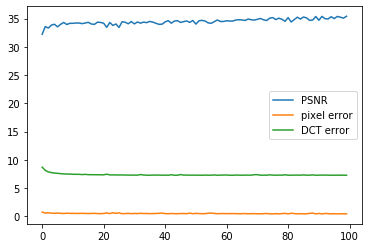

In [69]:

model = JDCTNet().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

hist_psnr = []
hist_err_px = []
hist_err_dct = []
best_epoch = None
best_cond = 0

model.train()
for epoch in range(EPOCHS):
    train_loss = 0
    str_epoch = f'Epoch: {epoch+1}/{EPOCHS} [{best_epoch}]'
    for batch_idx, (x, y) in enumerate(loader):
        x = Variable(x).to(device)
        y = Variable(y).to(device)
        optimizer.zero_grad()
        r, c = model(x)
        loss = F.l1_loss(x, r) + F.l1_loss(c, y)
        train_loss += loss.data.item()
        loss.backward()
        optimizer.step()
        sys.stderr.write(f'==>   {str_epoch} - ' + 
                         f'{batch_idx * BATCH_SIZE * 100 / len(train_dataset):.2f}% ' +
                         f'loss: {loss.data.item():.6f}        \r')
    
    train_loss /= (batch_idx + 1)
    sys.stderr.write(f'Train {str_epoch} Average loss: {train_loss:.6f}\n')

    model.eval()
    psnr, err_px, err_dct = 0, 0, 0
    for i in range(len(test_dataset)):
        patches, dcts = test_dataset[i]
        re_px, re_dct = predict_image(model, patches, BATCH_SIZE*10)
        _psnr, _e_px, _e_dct = estimate_image(re_px, re_dct, patches, dcts, 
                                              test_dataset.rects[i], test_dataset.images[i])
        psnr += _psnr
        err_px += _e_px
        err_dct += _e_dct
        sys.stdout.write(f'==>   {str_epoch} - ' +
                         f'{(i+1)*100/len(test_dataset):.2f}% ' +
                         f'PSNR: {_psnr:.4f}, pixel error: {_e_px:.4f} DCT error: {_e_dct:.4f}         \r')
        
    psnr /= len(test_dataset)
    err_px /= len(test_dataset)
    err_dct /= len(test_dataset)
    hist_psnr.append(psnr)
    hist_err_px.append(err_px)
    hist_err_dct.append(err_dct)
    print(f'Test  {str_epoch} ' + 
          f'PSNR: {psnr:.4f}, pixel error: {err_px:.4f} DCT error: {err_dct:.4f}                  ')
    
    cond = err_px + err_dct
    if best_epoch is None or cond < best_cond:
        best_cond = cond
        best_epoch = epoch + 1
        torch.save(model.state_dict(), MODEL_FILE)

plt.plot(hist_psnr, label='PSNR')
plt.plot(hist_err_px, label='pixel error')
plt.plot(hist_err_dct, label='DCT error')
plt.legend()
plt.show()


## Simulation Results

We select one image from the Kodak dataset and see the approximation result. The original image and reconstructed image of PSNR 36.54 are listed below. Ten 8x8 blocks are randomly selected from the image for a detailed comparison. Although the DCT approximation error is a bit higher as 7.2802, the obtained latent code does mimic the energy compaction effect of the DCT transform. 

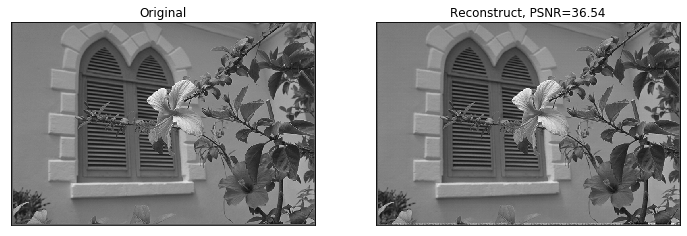

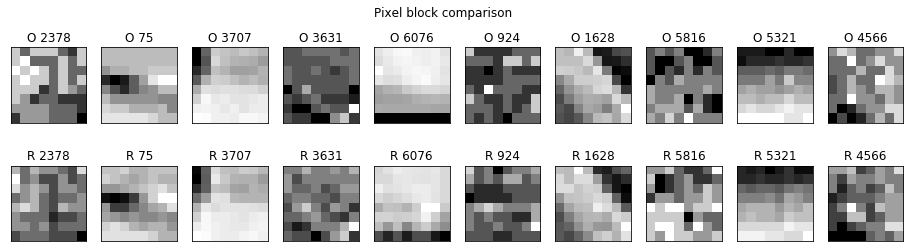

DCT block comparison
2378 = 
[[[1118    4    0    0    0    0    1   -1]
  [   3    0    1    0    1    0    1    0]
  [  -1    0   -1    0    1    0    0    0]
  [  -1    0    0    0    1    0    0    1]
  [   0    0    0   -1    0    0    0    0]
  [   1    0   -1   -1    1    0    0    0]
  [   0    1   -1    0    1    0    0    0]
  [   0    0    0    0   -1    1    1    1]]

 [[1116    0    0    0    0   -1    0   -1]
  [   4    1    0    0    0    0    0    0]
  [  -5   -6   -6   -6    0    0    0    0]
  [   0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0]]]
75 = 
[[[781  -7   1   3   0   1   0   0]
  [  0  -5   0  -1   0   0   0   0]
  [ 15  15  -3  -3  -1  -1   0   0]
  [ -6   5   2   0   0   0   0   0]
  [ -3  -9   1   2   1   0   0   0]
  [  0  -4   0   0  -1   0   0   0]
  [  2   3  -1  -1   0  -1   0   0]
  [  

In [70]:

model.load_state_dict(torch.load(MODEL_FILE))

im_idx = 3
patches, dcts = test_dataset[im_idx]
model.eval()
re_px, re_dct = predict_image(model, patches, BATCH_SIZE*10)
im = reconstruct_image(re_px, test_dataset.rects[im_idx], test_dataset.images[im_idx].size)
psnr, e_px, e_dct = estimate_image(re_px, re_dct, patches, dcts, test_dataset.rects[im_idx], 
                                   test_dataset.images[im_idx])

figure, axis = plt.subplots(1, 2, figsize=(12,8))
axis[0].set_title('Original')
axis[0].imshow(test_dataset.images[im_idx], cmap='gray')
axis[0].get_xaxis().set_visible(False)
axis[0].get_yaxis().set_visible(False)
axis[1].set_title(f'Reconstruct, PSNR={psnr:.2f}')
axis[1].imshow(im, cmap='gray')
axis[1].get_xaxis().set_visible(False)
axis[1].get_yaxis().set_visible(False)
plt.show()

COMP_COL = 10
sel = [i for i in range(len(re_px))]
random.shuffle(sel)
sel = sel[:COMP_COL]

figure, axis = plt.subplots(2, COMP_COL, figsize=(16,4))
figure.suptitle('Pixel block comparison')
for i, idx in enumerate(sel):
    px = patches[idx].squeeze(0).cpu().numpy().astype(int)
    axis[0][i].set_title(f'O {idx}')
    axis[0][i].imshow(px, cmap='gray')
    axis[0][i].get_xaxis().set_visible(False)
    axis[0][i].get_yaxis().set_visible(False)
    axis[1][i].set_title(f'R {idx}')
    axis[1][i].imshow(re_px[idx], cmap='gray')
    axis[1][i].get_xaxis().set_visible(False)
    axis[1][i].get_yaxis().set_visible(False)
plt.show()

print('DCT block comparison')
for i, idx in enumerate(sel[:2]):
    dct = dcts[idx].squeeze(0).cpu().numpy().astype(int)
    re_dct[idx] = re_dct[idx].astype(int)
    comp = np.stack((dct.reshape(BK_SIZE, BK_SIZE), re_dct[idx].reshape(BK_SIZE, BK_SIZE)))
    print(f'{idx} = \n{comp}')